In [26]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg


import puv 



In [27]:
def ossi_data_reader(datafolder):
    '''
    author: Paul van Wiechen

    Function to read all WLOG_XXX files in a certain subfolder.
    Make sure that only WLOG_XXX files are in this folder and no other files.
    Only WLOG_XXX files with minimally 2 rows are appended to the dataframe.
    A correct WLOG_XXX file should contain a first line with OSSI configuration, and a second line (third row) with starting time
    Timestep and sampling frequency are retrieved from the first row. Starting time from the next row
    Returns a dataframe with a time column and pressure column in dbars
    '''

    ossi = pd.DataFrame({
        't': [],
        'p': []})

    directory = str(datafolder)

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            print('Currently concatenating file ' + f)
            ossi_raw = pd.read_csv(f, header=None, nrows=4, sep=',')
            if len(ossi_raw.index) > 2:
                t_0 = datetime(int(str(20) + ossi_raw[0][1][1:]), int(ossi_raw[1][1][1:]), int(ossi_raw[2][1][1:]),
                               int(ossi_raw[3][1][1:]), int(ossi_raw[4][1][1:]), int(ossi_raw[5][1][1:]))
                dt = 1 / float(ossi_raw[6][0][1:])
                ossi_tot = pd.read_csv(f, skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], header=None,
                                       sep=',', skipinitialspace=True).to_numpy().flatten()
                ossi_temp = pd.DataFrame({
                    't': np.array([t_0 + timedelta(seconds=dt * i) for i in range(len(ossi_tot))]),
                    'p': ossi_tot})

                ossi_temp.dropna(inplace=True)
                ossi_temp['p'] = ossi_temp['p'] * 1e5  # Bar to Pa

                ossi = pd.concat([ossi, ossi_temp], ignore_index=True)

    ossi['p'] = pd.to_numeric(ossi['p'])
    ossi['t'] = pd.to_datetime(ossi['t'])

    return ossi.set_index('t')


In [28]:
experimentFolder = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data"    #Grand map
dfp = ossi_data_reader(os.path.join(experimentFolder,'Ossi02_25-27'))                                                       #specific map for data OSSI

instrument = 'OSSI_02'          # Specific name instrument
sf = 10                          # Hz, sampling frequency
xRD = 117221.8                   # location x-coord
yRD = 559793.1                   # location y-coord
serial_number = '18.09.00.08'    # unique serial number

rho = 1028      # Density of sea water
g = 9.81        # Gravitational force
zb = -1.43      # Height of sea bed (NAP)
zi = -1.30      # Height of instrument (NAP)

knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\uurgeg_330_2021-2030.txt"

ds = dfp.to_xarray()
ds['p'] = ds.p.astype('int32')
ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

# add global attribute metadata
ds.attrs = {
    'Conventions': 'CF-1.6',
    'name': '{}'.format(instrument),
    'instrument': '{}'.format(instrument),
    'instrument type': 'OSSI',
    'instrument serial number': '{}'.format(serial_number),
    'epsg': 28992,
    'x': xRD,
    'y': yRD,
    'sf': 10,
    'time zone': 'UTC+2',
    'summary': 'SEDMEX field campaign',
    'contact person': 'Marlies van der Lugt',
    'emailadres': 'm.a.vanderlugt@tudelft.nl',
    'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
    'version': 'v1',
    'version comments': 'constructed with xarray'}

#if nothing else, at least specify lossless zlib compression
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in ds.data_vars}

# save to file
if not os.path.isdir(os.path.join(experimentFolder,'raw_netcdf')):
    os.mkdir(os.path.join(experimentFolder,'raw_netcdf'))
ncFilePath = os.path.join(experimentFolder, 'raw_netcdf', instrument + '.nc')
ds.to_netcdf(ncFilePath)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_001.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_002.CSV


C:\Users\ruro\AppData\Local\Temp\ipykernel_5432\1382462514.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ossi = pd.concat([ossi, ossi_temp], ignore_index=True)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_003.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_02_data\Ossi02_25-27\WLOG_004.CSV


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ruro\\OneDrive - Boskalis\\Documents\\python\\01-Fieldwork\\Pressure_sensors\\OSSI\\OSSI_02_data\\raw_netcdf\\OSSI_02.nc'

In [ ]:
ds

<xarray.Dataset> Size: 49MB
Dimensions:  (t: 4061801)
Coordinates:
  * t        (t) datetime64[ns] 32MB 2024-09-25T12:31:00 ... 2024-09-27T20:57...
Data variables:
    p        (t) int32 16MB 1576 1657 1616 1598 1608 ... 1652 1651 1651 1651
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      OSSI_02
    instrument:                OSSI_02
    instrument type:           OSSI
    instrument serial number:  18.09.00.08
    epsg:                      28992
    ...                        ...
    summary:                   SEDMEX field campaign
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     02-Dec-2024 (11:20:53)
    version:                   v1
    version comments:          constructed with xarray

In [ ]:
dataFile = os.path.join(experimentFolder,'raw_netcdf', instrument +'.nc')
ds0 = xr.open_dataset(dataFile)
instr = ds0.instrument

# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(knmiFile, 330)           # Adjust station number

dt = ((ds0.t[1] - ds0.t[0]) / np.timedelta64(1, 's')).values # target frequency

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

############
first_real_value = ds0['pAir'].dropna(dim='t', how='all').isel(t=0)
ds0['dpAir'] = ds0['pAir'] - first_real_value
# ds0['dpAir'] = ds0['pAir']
##########
# we correct for drift in air pressure, nothing else
# ds0['dpAir'] = ds0['pAir'] - ds0['pAir'].isel(t=0)

# correct the pressure signal with dpAir and with drift in instrument pressure
ds0['pc'] = ds0['p'] -ds0['p'].min() - ds0['dpAir']
# ds0['pc'] = ds0['p'] -ds0['p'].min()
ds0['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

# -----------------------------------------------------------------------------


c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in

In [ ]:
print(ds0.t)

<xarray.DataArray 't' (t: 4061801)> Size: 32MB
array(['2024-09-25T12:31:00.000000000', '2024-09-25T12:31:00.050000000',
       '2024-09-25T12:31:00.100000000', ..., '2024-09-27T20:57:35.000000000',
       '2024-09-27T20:57:35.050000000', '2024-09-27T20:57:35.100000000'],
      dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 32MB 2024-09-25T12:31:00 ... 2024-09-27T20:57...


In [ ]:
# Specify your desired start timestamp
desired_start_time = pd.Timestamp("2024-09-26T00:00:00.00")

# Ensure both the desired start time and the time array are of type datetime64[ns]
desired_start_time = np.datetime64(desired_start_time)
time_array = ds0.t.values.astype("datetime64[ns]")  # Ensure time array is also datetime64[ns]

# Find the index corresponding to the closest time to the desired start time
start_index = np.searchsorted(time_array, desired_start_time)

# Ensure the index is valid and divisible by the burst length
dt = ds0.isel(t=1).t - ds0.isel(t=0).t  # Time step
sf = np.timedelta64(1, 's') / dt.values  # Sampling frequency

D_length = '1200S'

burstDuration = pd.Timedelta(D_length)  # Burst duration (1200 seconds = 20 minutes)
burstLength = int(burstDuration / dt)  # Number of samples per burst

# Adjust the starting index to align with the burst length
start_index = (start_index // burstLength) * burstLength

# Calculate the total number of samples and bursts
nSamples = len(ds0.pc.values)
nBursts = int(np.floor((nSamples - start_index) / burstLength))

# Subset the data starting from the adjusted index
pt = ds0.pc.values[start_index:start_index + nBursts * burstLength]
t = ds0.t.values[start_index::burstLength][:nBursts]  # Ensure time array is compatible

# Calculate the time vector for each burst
N = (time_array[:burstLength] - time_array[0]) / np.timedelta64(1, 's')

# Outputs
print(f"Start Index: {start_index}")
print(f"Number of Bursts: {nBursts}")
print(f"Sampling Frequency: {sf} Hz")
print(f"Time Vector (N): {N}")

# --------------------------------------------------------------------------
# cast into a 2D array
ds = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})
# copy all data over into this new structure
ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds['zi'] = zi
ds['zb'] = zb
ds['sf'] = sf

# remove all bursts where instrument fell dry
ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

# --------------------------------------------------------------------------
# pdb.set_trace()
ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds.attrs = ds0.attrs
ds.attrs['summary'] = 'SEDMEX field campaign, pressure corrected for air pressure and cast in bursts of 10 minutes'
ds['name'] = instr

Start Index: 816000
Number of Bursts: 135
Sampling Frequency: 20.0 Hz
Time Vector (N): [0.00000e+00 5.00000e-02 1.00000e-01 ... 1.19985e+03 1.19990e+03
 1.19995e+03]


C:\Users\ruro\AppData\Local\Temp\ipykernel_5432\627848511.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  burstDuration = pd.Timedelta(D_length)  # Burst duration (1200 seconds = 20 minutes)
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
print(burstLength)

24000


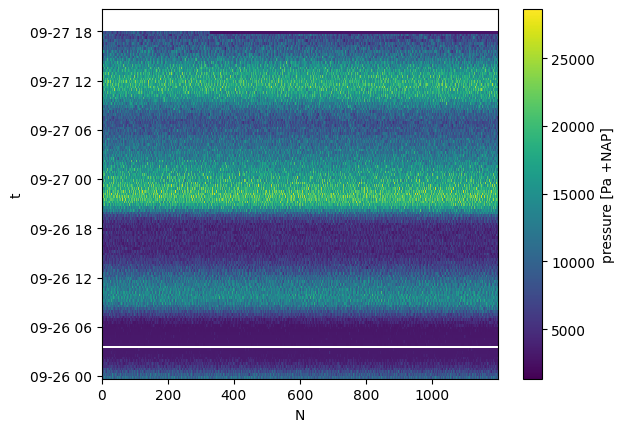

In [ ]:
ds.p.plot();

In [ ]:
def find_burst_index_for_time(time_vector, burst_length, specific_time):
    """
    Find the burst index corresponding to a specific timestamp.

    Parameters:
        time_vector (numpy array): Array of timestamps for each burst.
        burst_length (int): Number of samples per burst.
        specific_time (str or pd.Timestamp): The specific time to search for.

    Returns:
        int: The burst index corresponding to the specific timestamp.
    """
    specific_time = np.datetime64(specific_time)  # Ensure the timestamp is datetime64
    index = np.searchsorted(time_vector, specific_time)  # Find closest burst start
    if index >= len(time_vector):
        index = len(time_vector) - 1  # Handle case where timestamp is beyond the range
    return index

# Example usage of the function
specific_time = "2024-09-27T06:58:00.000000000"  # Replace with your desired time
burst_index = find_burst_index_for_time(t, burstLength, specific_time)
print(burst_index)

94


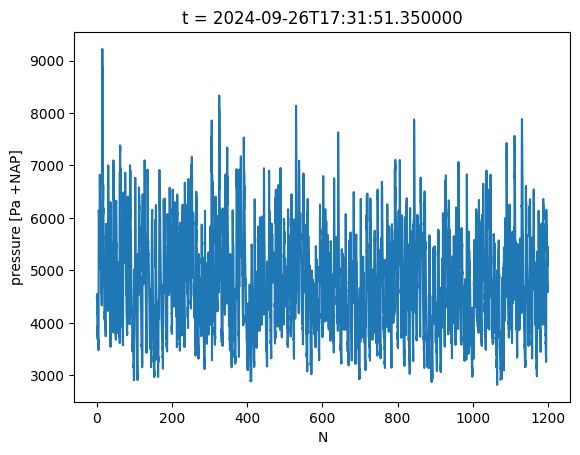

In [ ]:
# ds.p.isel(t=53).plot()
from scipy.signal import detrend
data_test = ds.p.isel(t=53) 
# data_test = detrend(data_test)

# data_test = data_test - data_test.mean()


# print(data_test)
# # data_test.head()
# print(len(data_test)) # 1200 sec * 20 hz = 24000 samples
# print(data_test.mean())
# plt.plot(np.linspace(0, len(data_test), len(data_test)),data_test )
# plt.axhline(data_test.mean(), color='r')

# print(data_test.values)

data_test.plot()

In [ ]:
import puv

1.0259156368836806
[1.49552625 1.49062646 1.47344828 ... 0.7282344  0.77161986 0.77575669]
1.0457855625725585


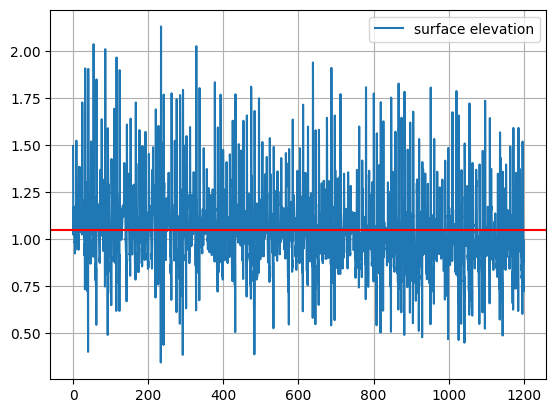

In [ ]:
sf = f = 20
x = data_test.values
hmean = h = data_test.mean().values / 1E4 #+ np.abs(zb - zi)
print(hmean)

t, zs = puv.attenuate_signal('pressure',f,x,hmean,zi,zb, detrend=True)
# zs = detrend(zs)
print(zs)

# Remove points below 0.0
mask = zs >= 0.0  # Create a boolean mask for values >= 0.0
t = t[mask]       # Filter the time array
zs = zs[mask]     # Filter the zs array

# t = np.arange(0,len(x)/f, 1/f)
plt.plot(t, zs, label='surface elevation')
plt.axhline(zs.mean(),color='r')
# plt.xlim(0,200)
plt.grid()
plt.legend();

print(zs.mean())

In [ ]:
Nr = len(x)
deltaf = f/Nr
ff = deltaf*np.append(np.arange(0,np.round(Nr/2)),
                          - np.arange(np.round(Nr/2),0,-1))

p_blocks = 20
D_block = 1200 #[sec]
fresolution = p_blocks / D_block 

# ff = np.arange(0, sf / 2, fresolution) 
# what is freq. resolution in puv.attenuete_signal() ?

w = 2*np.pi*ff
w2 = w**2*h/g
q = w2 / (1-np.exp(-w2**(5/4)))**(2/5)

# puv.dis
print(ff)
# print(w)

# print(w2)
# print(zs)

# Conclusion: frequency axis is wrongly calculated in puv.attenuation_signal()


[ 0.          0.00083333  0.00166667 ... -0.0025     -0.00166667
 -0.00083333]


C:\Users\ruro\AppData\Local\Temp\ipykernel_5432\3019577507.py:15: RuntimeWarning: invalid value encountered in divide
  q = w2 / (1-np.exp(-w2**(5/4)))**(2/5)


In [ ]:
# frequency resolution in fourier space
### delta_f = p_blocks/D_timeframe ###
p_blocks = 1 
D_length = 1200
fresolution = p_blocks / D_length
print(fresolution)


0.0008333333333333334


In [ ]:
import scipy.signal              # importing scipy.signal package for detrending
from scipy.fftpack import fft    # importing Fourier transform package
from scipy.stats import chi2     # importing confidence interval package
import oceanwaves as ow          # package of functions related to waves

def wave_spectrum(data,nBlocks,Fs):
    ''' Compute variance density spectrum from a given time-series and its 
    90% confidence intervals. 
    The time-series is first divided into nBlocks blocks (of length nfft = [total length]/nBlocks) before being 
    Fourier-transformed 
    Note that this is one of the simplest ways to estimate the variance density spectrum 
    (no overlap between the blocks, and use of a rectangular window) - see for instance 
    scipy.signal.welch for more advanced spectral calculations.

    INPUT
      data    timeseries 
      nBlocks  number of blocks
      Fs     sampling frequency of the timeseries (Hz)
    
    OUTPUT
      E       (one-sided) variance spectral density. If data is in pa, E is in pa^2/Hz
      f       frequency axis (Hz)
      confLow and confUpper     Lower and upper 90% confidence interval; 
                                (Multiplication factors for E)  '''
    # 1. PRELIMINARY CALCULATIONS
    # ---------------------------
    n = len(data)                # length of the time-series
    nfft = int(n/nBlocks)
    nfft = int(nfft - (nfft%2))
    data_new = data[0:nBlocks*nfft] # (we work only with the blocks which are complete)

    # we organize the initial time-series into blocks of length nfft 
    dataBlock = np.reshape(data_new,(nBlocks,nfft))  # each column of dataBlock is one block
    
    # 2. CALCULATION VARIANCE DENSITY SPECTRUM
    # ----------------------------------------

    # definition frequency axis
    df = Fs/nfft      # frequency resolution of the spectrum df = 1/[Duration of one block]
    f = np.arange(0,Fs/2+df,df)   # frequency axis (Fs/2 = Fnyquist = max frequency)
    fId = np.arange(0,len(f))

    # Calculate the variance for each block and for each frequency
    fft_data = fft(dataBlock,n = nfft,axis = 1)/nfft    # Fourier transform of the data
    fft_data = 2*fft_data[:,fId]                        # Only one side needed
     
    E = np.abs(fft_data)**2/2                  # E(i,b) = ai^2/2 = variance at frequency fi for block b 
    # We finally average the variance over the blocks, and divide by df to get the variance DENSITY spectrum
    E = np.mean(E, axis = 0)/df
    
    # 3. CONFIDENCE INTERVALS
    # -----------------------
    edf = round(nBlocks*2)   # Degrees of freedom 
    alpha = 0.1              # calculation of the 90% confidence interval

    confLow = edf/chi2.ppf(1-alpha/2,edf)    # see explanations on confidence intervals given in lecture 3 
    confUpper  = edf/chi2.ppf(alpha/2,edf)
    
    return E,f,confLow,confUpper


In [3]:
data = zs - zs.mean()
# print(data.dims)
nBlocks = 1
Fs = 20 

E,f,conflow,confupper = wave_spectrum(data,nBlocks,Fs)


NameError: name 'zs' is not defined

In [ ]:
print(data)
print(E.max())
print(E.mean())
print(conflow, confupper)

[ 0.44974069  0.44484089  0.42766272 ... -0.31755116 -0.2741657
 -0.27002887]
0.21607039523008198
0.003833502992676616
0.7173796795987227 1.5089042402664807


602


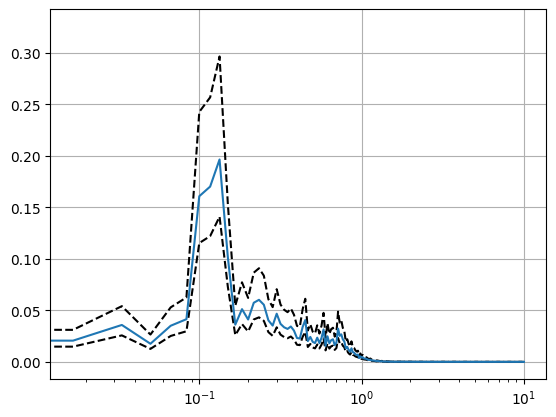

In [35]:
plt.plot(f, E*conflow, '--', color= 'black')
plt.plot(f, E*confupper, '--', color='black')
plt.plot(f,E)
plt.grid()
# plt.xlim(0,0.5)
plt.xscale('log')
# plt.yscale('log')

print(len(E))

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import matplotlib.pyplot as plt

# # Example DataFrame
# # df = pd.DataFrame({'t': [0, 0.1, 0.2, 0.3, ...], 'p': [pressure values]})
# # Replace this with your actual DataFrame
# t = df['t'].values  # Time values
# p = df['p'].values  # Pressure values

# Compute the sampling frequency (fs)
# dt = np.mean(np.diff(t))  # Average time step
# fs = 1 / dt  # Sampling frequency in Hz

fs = 20
nperseg=2400
p = zs


# Apply Welch's method
frequencies, psd = welch(p, fs=fs, nperseg=nperseg, detrend='constant', window='hann')

# Plot the spectral density
plt.figure(figsize=(10, 6))

plt.semilogy(frequencies, psd, label='Power Spectral Density')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title('Power Spectral Density using Welch\'s Method')
plt.grid()
plt.yscale('linear')
plt.xscale('log')
plt.legend()
plt.show()


NameError: name 'zs' is not defined

Significant Wave Height (Hm0): 0    0.675978
Name: m0, dtype: float64
Peak Period (Tp): 8.571428571428571
Mean Wave Period (Tm01): 0    4.272004
dtype: float64
Zero Crossing Period (Tm02): 0    3.611599
dtype: float64
Spectral Width (Tmm10): 0    6.69415
dtype: float64
Smoothed Peak Period (Tps): 8.380763610237505


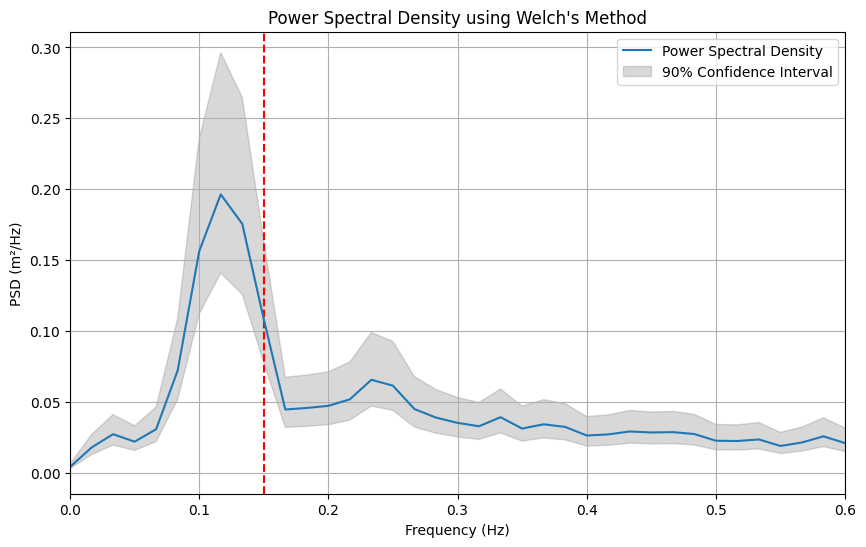

In [ ]:
fmin = 0.004  # Minimum frequency of interest
fmax = 0.6   # Maximum frequency of interest

# Call compute_wave_params
Hm0, Tp, Tm01, Tm02, Tmm10, Tps = puv.compute_wave_params(
    frequencies, psd, fmin=fmin, fmax=fmax, returntype='list'
)


# Step 2: Calculate confidence intervals
nBlocks = len(p) // nperseg  # Estimate the number of blocks used by Welch's method
edf = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
alpha = 0.1                  # 90% confidence level

confLow = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit

# Confidence interval bounds for PSD
psd_lower = psd * confLow
psd_upper = psd * confUpper

# Step 3: Print or use the computed wave parameters
print("Significant Wave Height (Hm0):", Hm0)
print("Peak Period (Tp):", Tp)
print("Mean Wave Period (Tm01):", Tm01)
print("Zero Crossing Period (Tm02):", Tm02)
print("Spectral Width (Tmm10):", Tmm10)
print("Smoothed Peak Period (Tps):", Tps)

# Step 4: Plot the PSD for visualization
plt.figure(figsize=(10, 6))
plt.axvline(0.15, color='r', linestyle='--')

plt.semilogy(frequencies, psd, label='Power Spectral Density')
plt.fill_between(frequencies, psd_lower, psd_upper, color='gray', alpha=0.3, label='90% Confidence Interval')


plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title('Power Spectral Density using Welch\'s Method')
plt.grid()
plt.yscale('linear')
# plt.xscale('log')
plt.xscale('linear')
plt.xlim(0,0.6)
plt.legend()
plt.show()

In [2]:
print(len(psd))
print(len(p))
print(edf)
print(len(t))
print(len(frequencies))

NameError: name 'psd' is not defined

In [ ]:
# # reshape to one row per burst in data array
# pt = ds0.pc.values
# nSamples = len(pt)
# dt = ds0.isel(t=1).t - ds0.isel(t=0).t
# sf = np.timedelta64(1, 's') / dt.values

# burstDuration = pd.Timedelta('1200S')
# burstLength = int(burstDuration / dt)
# nBursts = int(np.floor(nSamples / burstLength))

# pt = pt[:nBursts * burstLength]
# t = ds0.t[::burstLength]
# t = t[:nBursts]
# N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')
# # pdb.set_trace()

# # --------------------------------------------------------------------------
# # cast into a 2D array
# ds = xr.Dataset(data_vars={},
#                 coords={'t': t, 'N': N})
# # copy all data over into this new structure
# ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
# ds['zi'] = zi
# ds['zb'] = zb
# ds['sf'] = sf

# # remove all bursts where instrument fell dry
# ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

# # --------------------------------------------------------------------------
# # pdb.set_trace()
# ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
# ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
# ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
# ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
# ds.attrs = ds0.attrs
# ds.attrs['summary'] = 'SEDMEX field campaign, pressure corrected for air pressure and cast in bursts of 10 minutes'
# ds['name'] = instr
# if not os.path.isdir(os.path.join(experimentFolder, 'QC')):
#     os.mkdir(os.path.join(experimentFolder,'QC'))
# ncFilePath = os.path.join(experimentFolder, 'QC', instr + '.nc')
# ds.to_netcdf(ncFilePath)